## Subsampling analysis

subsample the number of inidvidualas/RNA-seq datasets and look at how number of signals changes

In [2]:
import pandas as pd
import numpy as np
import os
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
import ast

import upsetplot as up
from tqdm.auto import tqdm  # for notebooks
tqdm.pandas()

# load R for some R cells
%load_ext rpy2.ipython


prefix = '/home/klawren/oak/pcqtls'

import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from notebook_helper_functions import *

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


I then run snakemake on each sumsample made with 'make_subsamples.ipynb' to get QTLs with config files in config/subsampling/


this next analysis assumes results in those folders

In [3]:
subsample_output_folder = f'{prefix}/config/subsampling'

### configs across subsamples

In [4]:
# load in the configs for each 

subsample_nums = [100,200,300]

sub_configs = {}
for num_samples in subsample_nums:
    config_path= f'{subsample_output_folder}/{num_samples}_subsample.yaml'
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
        sub_configs[num_samples] = config

main_config_path= f'{prefix}/config/proteincoding_main.yaml'
with open(main_config_path, 'r') as f:
    final_output_config = yaml.safe_load(f)


tissue_ids = load_tissue_ids(final_output_config)
tissue_df = load_tissue_df(final_output_config)
tissue_pal = sns.color_palette('blend:#B83A4B,#FEC51D,#67AFD2', n_colors=len(tissue_ids))


my_tissue_id = tissue_ids[3]

## number of singals of each group across sample sizes

In [5]:
sample_sizes = pd.read_csv(final_output_config['gtex_meta'], sep='\t')

In [6]:
sub_signals = {}
for i in subsample_nums:
    sub_signals[i] = load_signal_groups(sub_configs[i], my_tissue_id)


final_sample_size = sample_sizes[sample_sizes['tissue_id']==my_tissue_id]['sample_size'].values[0]
sub_signals[final_sample_size] = load_signal_groups(final_output_config, my_tissue_id)

sub_signals = pd.concat(sub_signals, names=['num_samples', 'idx']).reset_index()
sub_signals['exclusive_label'] = np.where((sub_signals['num_e_coloc'] > 0), np.where((sub_signals['num_pc_coloc'] > 0), 'shared', 'eqtl_only'), 'pcqtl_only')

/home/klawren/oak/pcqtls/output/subsampling_constant_clusters/100/coloc//pairs/Cells_Cultured_fibroblasts.v8.pairs_coloc.chr18.txt is empty


<AxesSubplot: xlabel='num_samples', ylabel='Count'>

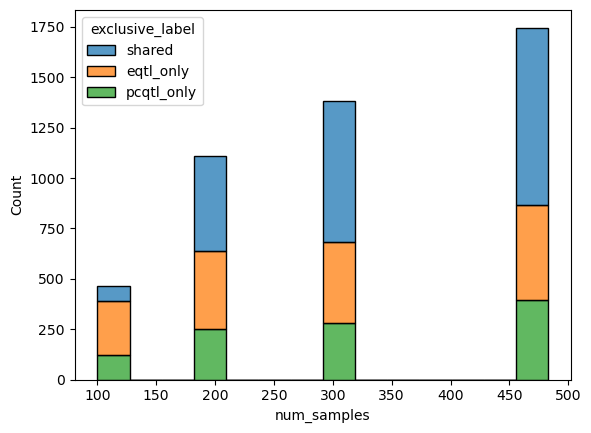

In [8]:
sns.histplot(sub_signals, x='num_samples', hue='exclusive_label', multiple='stack')

## coloc unique pcqtl signals in subsamples to eqtl signals with more samples

In [9]:
def get_lead_var_shared(sub_groups, full_groups):

    # if any share a lead variant, we assume those are the same signal and don't need to do a full coloc

    potential_lead_var_shared = pd.merge(sub_groups, full_groups, on=['cluster_id', 'tissue_id'], suffixes=['_sub', '_full'])
    potential_lead_var_shared = potential_lead_var_shared.explode('lead_var_set_full').explode('lead_var_set_sub')
    # take only the ones that share lead variants
    lead_var_shared = potential_lead_var_shared[potential_lead_var_shared['lead_var_set_full']==potential_lead_var_shared['lead_var_set_sub']]
    # drop duplicates, so only unique sub-full combinations
    lead_var_shared = lead_var_shared.drop_duplicates(['signal_id_full', 'signal_id_sub', 'cluster_id', 'tissue_id'])

    # group around sub singal sets
    lead_var_shared = lead_var_shared.groupby(['signal_id_sub', 'cluster_id', 'tissue_id']).agg({'signal_id_full':list, 
                                                                                                'num_e_coloc_sub':'first', 
                                                                                                'num_pc_coloc_sub':'first',
                                                                                                'num_e_coloc_full':'sum',
                                                                                                'num_pc_coloc_full':'sum'}).reset_index()

    print('{} small sample share a lead var with a large sample'.format(lead_var_shared['signal_id_sub'].nunique()))
    return lead_var_shared

def get_coloc_subsample(sub_config, sub_groups, full_config, full_groups, lead_var_shared):

    # get the sub credible sets that didn't have a shared lead var
    remaining_sub_groups = sub_groups[~sub_groups['signal_id'].isin(lead_var_shared['signal_id_sub'])]

    # these don't have matching lead variant annotaitons, not sure why?
    # it appears to be all the longer clusters
    # filter out larger clusters and see if any are still unmatched

    remaining_sub_groups = remaining_sub_groups[remaining_sub_groups['cluster_id'].apply(len)<150]
    print("{} of the small sample signals don't share a lead var, will need to be colocd".format(len(remaining_sub_groups)))


    # for the remaining ones, do a full coloc 
    full_groups['cs_id'] = full_groups['signal_id'].str.split('-')
    full_groups = full_groups.explode('cs_id')
    remaining_sub_groups['cs_id'] = remaining_sub_groups['signal_id'].str.split('-')
    remaining_sub_groups = remaining_sub_groups.explode('cs_id')

    groups_merged = pd.merge(remaining_sub_groups, full_groups, on=['cluster_id', 'tissue_id'], suffixes=['_sub', '_full'] )

    # add the paths for the susies
    def get_susie_path(phenotype_id, config, tissue_id):
        if len(phenotype_id) > 150:
            # Split the long QTL ID by underscores
            long_qtl_id_split = phenotype_id.split("_")
            phenotype_id = "_".join(long_qtl_id_split[-5:])
        return '{}/{}temp/{}/{}.susie.rds'.format(prefix, config['coloc_output_dir'], tissue_id, phenotype_id)

    groups_merged['susie_path_full'] = groups_merged['cs_id_full'].str.split('_cs').str[0].apply(get_susie_path, args=(full_config, my_tissue_id))
    groups_merged['susie_path_sub'] = groups_merged['cs_id_sub'].str.split('_cs').str[0].apply(get_susie_path, args=(sub_config, my_tissue_id))

    # add credible set index labels
    groups_merged['cs_num_sub'] = groups_merged['cs_id_sub'].str.split('_cs_').str[-1]
    groups_merged['cs_num_full'] = groups_merged['cs_id_full'].str.split('_cs_').str[-1]

    # # do you really need to colocalize between every pair of singals in an already coloc'd group?
    # # try with just 1 singal from each instead
    groups_merged_pruned = groups_merged.drop_duplicates(['signal_id_sub', 'signal_id_full', 'tissue_id'])
    groups_merged_pruned['pph4']=0
    print('{} colocs if we do every combination'.format(len(groups_merged)))
    print('{} colocs if we do 1 credible set per signal group'.format(len(groups_merged_pruned)))

    return groups_merged_pruned

# combine the shared lead var, coloc'd, and unique signals
def combine_signals(sub_groups, lead_var_shared, groups_merged_pruned):

    # regrouping is necessary if you don't first prune the signals 
    groups_merged_pruned = groups_merged_pruned.groupby(['signal_id_sub', 'signal_id_full', 'cluster_id', 'tissue_id']).agg({'num_e_coloc_sub':'first', 
                                                                                                    'num_pc_coloc_sub':'first',
                                                                                                    'num_e_coloc_full':'first',
                                                                                                    'num_pc_coloc_full':'first',
                                                                                                    'pph4':'max'}).reset_index()

    # take only the coloc signals
    groups_colocd = groups_merged_pruned[groups_merged_pruned['pph4'] > .75]
    print('{} subsignals had a signifigant coloc'.format(groups_colocd['signal_id_sub'].nunique()))
    groups_colocd = groups_colocd.groupby(['signal_id_sub', 'cluster_id', 'tissue_id']).agg({'num_pc_coloc_sub':'first', 
                                                                                    'num_e_coloc_sub':'first', 
                                                                                    'num_e_coloc_full':'sum',
                                                                                    'num_pc_coloc_full':'sum', 
                                                                                    'pph4':list, 
                                                                                    'signal_id_full':list}).reset_index()

    shared_signals = pd.concat([lead_var_shared, groups_colocd])

    # merge back in all the groups
    groups_no_colocd = sub_groups[~sub_groups['signal_id'].isin(shared_signals['signal_id_sub'])]
    groups_no_colocd['num_e_coloc_full'] = 0
    groups_no_colocd['num_pc_coloc_full'] = 0
    groups_no_colocd['num_e_coloc_sub'] = groups_no_colocd['num_e_coloc']
    groups_no_colocd['num_pc_coloc_sub'] = groups_no_colocd['num_pc_coloc']
    groups_no_colocd['signal_id_sub'] = groups_no_colocd['signal_id']

    print('{} signals non overlapping'.format(groups_no_colocd['signal_id'].nunique()))


    coloc_annotated_signals = pd.concat([shared_signals, groups_no_colocd[['signal_id_sub', 'num_e_coloc_full', 'num_pc_coloc_full', 'num_e_coloc_sub', 'num_pc_coloc_sub', 'cluster_id', 'tissue_id']]])
    print('{} signals had a coloc or shared lead var'.format(coloc_annotated_signals['signal_id_sub'].nunique()))

    # TODO (fix this/remove this) filter out the large clusters (an bug in the code for these)
    coloc_annotated_signals = coloc_annotated_signals[coloc_annotated_signals['cluster_id'].apply(len)<150]

    coloc_annotated_signals['exclusive_label_full'] = np.where((coloc_annotated_signals['num_e_coloc_full'] > 0), np.where((coloc_annotated_signals['num_pc_coloc_full'] > 0), 'shared', 'eqtl_only'), np.where((coloc_annotated_signals['num_pc_coloc_full'] > 0), 'pcqtl_only', 'neither'))
    coloc_annotated_signals['exclusive_label_sub'] = np.where((coloc_annotated_signals['num_e_coloc_sub'] > 0), np.where((coloc_annotated_signals['num_pc_coloc_sub'] > 0), 'shared', 'eqtl_only'), np.where((coloc_annotated_signals['num_pc_coloc_sub'] > 0), 'pcqtl_only', 'neither'))
    return coloc_annotated_signals

In [14]:
%%R -w 3 -h 5 --units in -r 200 
library(coloc)

get_coloc_from_df <- function(groups_merged_pruned){
    # Initialize values
    pph4_values <- numeric(nrow(groups_merged_pruned))
    skipped_files <- 0  # Counter for skipped files

    # Initialize progress bar
    pb <- txtProgressBar(min = 0, max = nrow(groups_merged_pruned), style = 3)

    # Loop over each row to get the PP.H4.abf value
    for (i in 1:nrow(groups_merged_pruned)) {
        tryCatch({
            susie_sub <- readRDS(file = groups_merged_pruned$susie_path_sub[i])
            susie_full <- readRDS(file = groups_merged_pruned$susie_path_full[i])
            # extract the value of PP.H4.abf that matches the credible set ids for this signal pair
            coloc_summary <- coloc.susie(susie_sub, susie_full)$summary
            matched_row <- coloc_summary[coloc_summary$idx1 == groups_merged_pruned$cs_num_sub[i] & coloc_summary$idx2 == groups_merged_pruned$cs_num_full[i], ]
            pph4_values[i] <- matched_row$PP.H4.abf[1]
        }, error = function(e) {
            # If an error occurs (e.g., file not found), assign 0 and increment the skipped file counter
            pph4_values[i] <- 0
            skipped_files <<- skipped_files + 1
            message(paste("Skipped file at index:", i, "due to error:", e$message))
        })
        
        # Update the progress bar
        setTxtProgressBar(pb, i)
    }

    # Close the progress bar
    close(pb)

    # Store the results back into the groups_merged_pruned dataframe
    groups_merged_pruned$pph4 <- pph4_values

    # Print the number of skipped files
    print(paste("Total skipped files:", skipped_files))
    return(groups_merged_pruned)
}

This is coloc version 5.2.3


In [19]:
%%R -i groups_merged_pruned -w 3 -h 5 --units in -r 200 -o groups_merged_pruned
i=3
susie_sub <- readRDS(file = groups_merged_pruned$susie_path_sub[i])
susie_full <- readRDS(file = groups_merged_pruned$susie_path_full[i])
str(susie_full)

List of 20
 $ alpha                 : num [1:10, 1:5633] 1.36e-33 6.59e-05 1.78e-04 1.78e-04 1.78e-04 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:5633] "chr1_152628280_C_T_b38" "chr1_152628378_G_T_b38" "chr1_152628442_C_T_b38" "chr1_152628471_G_A_b38" ...
 $ mu                    : num [1:10, 1:5633] -0.0188 -0.0221 0 0 0 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:5633] "chr1_152628280_C_T_b38" "chr1_152628378_G_T_b38" "chr1_152628442_C_T_b38" "chr1_152628471_G_A_b38" ...
 $ mu2                   : num [1:10, 1:5633] 0.00242 0.00229 0 0 0 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:5633] "chr1_152628280_C_T_b38" "chr1_152628378_G_T_b38" "chr1_152628442_C_T_b38" "chr1_152628471_G_A_b38" ...
 $ KL                    : num [1:10] 9.74 3.21 1.11e-16 1.11e-16 1.11e-16 ...
 $ lbf                   : num [1:10] 6.46e+01 1.10e-01 -1.11e-16 -1.11e-16 -1.11e-16 ...
 $ lbf_variable          : num [1:10, 1:5

In [18]:
%%R -i groups_merged_pruned -w 3 -h 5 --units in -r 200 -o groups_merged_pruned
i=3
susie_sub <- readRDS(file = groups_merged_pruned$susie_path_sub[i])
susie_full <- readRDS(file = groups_merged_pruned$susie_path_full[i])
summary(susie_sub)
str(susie_sub)

List of 20
 $ alpha                 : num [1:10, 1:5593] 1.63e-12 1.54e-04 1.53e-04 1.52e-04 1.50e-04 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:5593] "chr1_152628280_C_T_b38" "chr1_152628378_G_T_b38" "chr1_152628442_C_T_b38" "chr1_152628471_G_A_b38" ...
 $ mu                    : num [1:10, 1:5593] 0.01672 0.00345 0.00358 0.00375 0.00388 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:5593] "chr1_152628280_C_T_b38" "chr1_152628378_G_T_b38" "chr1_152628442_C_T_b38" "chr1_152628471_G_A_b38" ...
 $ mu2                   : num [1:10, 1:5593] 0.002313 0.000565 0.000587 0.000612 0.000634 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:5593] "chr1_152628280_C_T_b38" "chr1_152628378_G_T_b38" "chr1_152628442_C_T_b38" "chr1_152628471_G_A_b38" ...
 $ KL                    : num [1:10] 7.876 0.176 0.185 0.195 0.205 ...
 $ lbf                   : num [1:10] 16.62347 0.00597 0.00656 0.00729 0.00796 ...
 $ lbf_variabl

In [13]:
# pull out one subsample in particular to compare to full sample
# I want to get a df with each subsample id, and the num pc and num e signals in the full dataset that coloc with it
sub_num_samples = 100
sub_config = sub_configs[sub_num_samples]
sub_groups = sub_signals[sub_signals['num_samples']==sub_num_samples]
print('{} small sample size signals'.format(sub_groups['signal_id'].nunique()))

# get the full dataset group
full_groups = sub_signals[sub_signals['num_samples']==final_sample_size]
print('{} large sample size signals'.format(full_groups['signal_id'].nunique()))


# optionally, subset clusters
#full_groups = full_groups[full_groups['cluster_id'].isin(sub_groups['cluster_id'].unique()[:20])]
#sub_groups = sub_groups[sub_groups['cluster_id'].isin(sub_groups['cluster_id'].unique()[:20])]

lead_var_shared = get_lead_var_shared(sub_groups, full_groups)
groups_merged_pruned = get_coloc_subsample(sub_config, sub_groups, final_output_config, full_groups, lead_var_shared)

463 small sample size signals
1747 large sample size signals
79 small sample share a lead var with a large sample
384 of the small sample signals don't share a lead var, will need to be colocd
2921 colocs if we do every combination
1508 colocs if we do 1 credible set per signal group


/local/scratch/klawren/slrmtmp.46962791/ipykernel_7485/1516611404.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_groups['cs_id'] = full_groups['signal_id'].str.split('-')
/local/scratch/klawren/slrmtmp.46962791/ipykernel_7485/1516611404.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  groups_merged_pruned['pph4']=0


In [293]:
%%R -i groups_merged_pruned -w 3 -h 5 --units in -r 200 -o groups_merged_pruned
# run coloc for the pruned set in R
groups_merged_pruned <- get_coloc_from_df(groups_merged_pruned)


  |                                                                                                                                                                                              |   0%

/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning:

Error while trying to convert the column "lead_var_set_sub". Fall back to string conversion. The error is: <class 'list'>

/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning:

Error while trying to convert the column "lead_var_set_full". Fall back to string conversion. The error is: <class 'list'>



  |==============================================================================================================================================================================================| 100%
[1] "Total skipped files: 0"


In addition: Warning message:
In coloc.bf_bf(bf1, bf2, ...) :
  snp overlap too small between datasets: too few snps with high posterior in one trait represented in other


In [334]:
coloc_annotated_signals = combine_signals(sub_groups, lead_var_shared, groups_merged_pruned)

0 subsignals had a signifigant coloc
343 signals non overlapping
463 signals had a coloc or shared lead var


/local/scratch/klawren/slrmtmp.46962791/ipykernel_23369/1516611404.py:91: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/local/scratch/klawren/slrmtmp.46962791/ipykernel_23369/1516611404.py:92: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/local/scratch/klawren/slrmtmp.46962791/ipykernel_23369/1516611404.py:93: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

Text(0.5, 1.0, 'how does each small-sample signal coloc with the larger sample signals?')

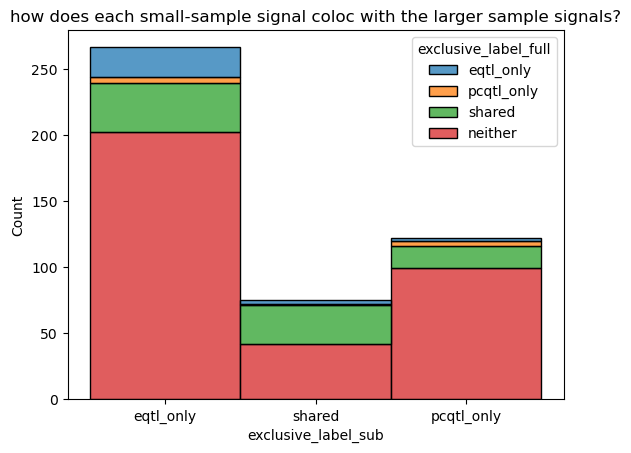

In [335]:
sns.histplot(coloc_annotated_signals, x='exclusive_label_sub', hue='exclusive_label_full', multiple='stack')
plt.title('how does each small-sample signal coloc with the larger sample signals?')

In [300]:
# make a flow diagram

import plotly.graph_objects as go

# Create dimensions
sub_dim = go.parcats.Dimension(
    values=coloc_annotated_signals.exclusive_label_sub,
    categoryorder='category ascending', label="small sample"
)

full_dim = go.parcats.Dimension(
    values=coloc_annotated_signals.exclusive_label_full,
    categoryorder='category ascending', label="large sample"
)

# Create parcats trace
color = coloc_annotated_signals.exclusive_label_sub;
colorscale = [['eqtl_only', 'lightsteelblue'], ['pcqtl_only', 'mediumseagreen'], ['shared', 'aliceblue']];

fig = go.Figure(data = [go.Parcats(dimensions=[sub_dim, full_dim],
        #line={'color': color, 'colorscale': colorscale},
        hoveron='color', hoverinfo='count+probability',
        arrangement='freeform')])

fig.show()



## for 100-200-300-full

In [ ]:
# for groups in the 100 to groups in the 200
subsample_size_1 = 100
subsample_size_2 = 200
lead_var_shared_200 = get_lead_var_shared(sub_signals[sub_signals['num_samples']==subsample_size_1], sub_signals[sub_signals['num_samples']==subsample_size_2])
groups_merged_pruned_200 = get_coloc_subsample(sub_configs[subsample_size_1], sub_signals[sub_signals['num_samples']==subsample_size_1], sub_configs[subsample_size_2], sub_signals[sub_signals['num_samples']==subsample_size_2], lead_var_shared)

# for groups in the 100 to groups in the 300
subsample_size_2 = 300
lead_var_shared_300 = get_lead_var_shared(sub_signals[sub_signals['num_samples']==subsample_size_1], sub_signals[sub_signals['num_samples']==subsample_size_2])
groups_merged_pruned_300 = get_coloc_subsample(sub_configs[subsample_size_1], sub_signals[sub_signals['num_samples']==subsample_size_1], sub_configs[subsample_size_2], sub_signals[sub_signals['num_samples']==subsample_size_2], lead_var_shared)

120 small sample share a lead var with a large sample
343 of the small sample signals don't share a lead var, will need to be colocd
2285 colocs if we do every combination
1515 colocs if we do 1 credible set per signal group


/local/scratch/klawren/slrmtmp.46962791/ipykernel_23369/3045040756.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/local/scratch/klawren/slrmtmp.46962791/ipykernel_23369/3045040756.py:61: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [319]:
%%R -i groups_merged_pruned_200 -w 3 -h 5 --units in -r 200 -o groups_merged_pruned_200
# run coloc for the pruned set in R
groups_merged_pruned_200 <- get_coloc_from_df(groups_merged_pruned_200)

/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning:

Error while trying to convert the column "lead_var_set_sub". Fall back to string conversion. The error is: <class 'list'>

/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning:

Error while trying to convert the column "lead_var_set_full". Fall back to string conversion. The error is: <class 'list'>



  |==============================================================================================================================================================================================| 100%
[1] "Total skipped files: 0"


In [ ]:
%%R -i groups_merged_pruned_300 -w 3 -h 5 --units in -r 200 -o groups_merged_pruned_300
# run coloc for the pruned set in R
groups_merged_pruned_300 <- get_coloc_from_df(groups_merged_pruned_300)

87 subsignals had a signifigant coloc
256 signals non overlapping
463 signals had a coloc or shared lead var


/local/scratch/klawren/slrmtmp.46962791/ipykernel_23369/1516611404.py:91: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/local/scratch/klawren/slrmtmp.46962791/ipykernel_23369/1516611404.py:92: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/local/scratch/klawren/slrmtmp.46962791/ipykernel_23369/1516611404.py:93: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

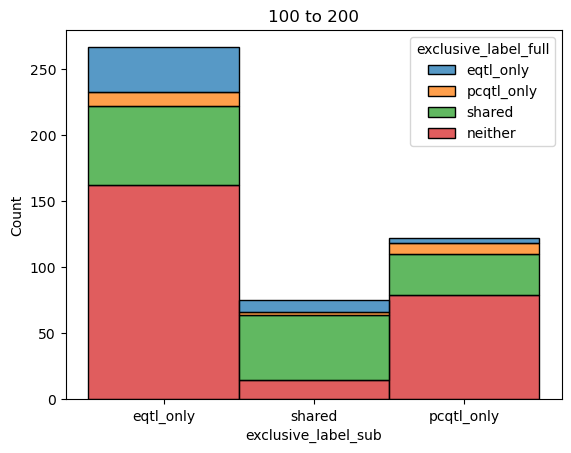

NameError: name 'lead_var_shared_300' is not defined

In [ ]:
# combine the shared lead var, coloc'd, and unique signals
coloc_annotated_signals_200 = combine_signals(sub_signals[sub_signals['num_samples']==100], lead_var_shared_200, groups_merged_pruned_200)
coloc_annotated_signals_300 = combine_signals(sub_signals[sub_signals['num_samples']==100], lead_var_shared_300, groups_merged_pruned_300)

In [ ]:
sns.histplot(coloc_annotated_signals_200, x='exclusive_label_sub', hue='exclusive_label_full', multiple='stack')
plt.title('100 to 200')
plt.show()
sns.histplot(coloc_annotated_signals_300, x='exclusive_label_sub', hue='exclusive_label_full', multiple='stack')
plt.title('100 to 300')
plt.show()

In [331]:
# combine all sets of signals

coloc_annotated_signals[['signal_id_sub', 'exclusive_label_sub', 'exclusive_label_full']]

,signal_id_sub,exclusive_label_sub,exclusive_label_full
0,ENSG00000006282.20_ENSG00000006283.17_e_ENSG00...,eqtl_only,shared
1,ENSG00000006282.20_ENSG00000006283.17_e_ENSG00...,eqtl_only,shared
2,ENSG00000007341.18_ENSG00000116489.12_e_ENSG00...,eqtl_only,shared
3,ENSG00000010626.14_ENSG00000111671.9_e_ENSG000...,shared,shared
4,ENSG00000010626.14_ENSG00000111671.9_e_ENSG000...,shared,shared
...,...,...,...
454,NaN,eqtl_only,neither
455,NaN,pcqtl_only,neither
457,NaN,pcqtl_only,neither
458,NaN,eqtl_only,neither


In [ ]:
coloc_annotated_signals_200[['signal_id_sub', 'exclusive_label_full']]

### old

In [10]:
def get_qtl_counts(tissue_id, config):
    overlap_df = pd.read_csv('{}/{}/{}.v8.overlap.txt'.format(prefix, config['overlap_output_dir'], tissue_id), sep='\t')
    return overlap_df.groupby('orig_cs_dataset').count()['cs_full_id']


def get_cluster_count(tissue_id, config):
    cluster_df = pd.read_csv('{}/{}/{}_clusters_all_chr.csv'.format(prefix, config['clusters_dir'], tissue_id))
    return len(cluster_df)

def get_egene_count(tissue_id, config):
    overlap_df = pd.read_csv('{}/{}/{}.v8.overlap.txt'.format(prefix, config['overlap_output_dir'], tissue_id), sep='\t')
    if len(overlap_df) == 0:
        return 0
    else:
        return overlap_df['cluster_id'].nunique()
    
def get_permutation_eqtl_count(tissue_id, config):
    permutation_df = load_e_permutation(config, tissue_id)
    return len(permutation_df)

def get_permutation_pcqtl_count(tissue_id, config):
    permutation_df = load_pc_permutation(config, tissue_id)
    return len(permutation_df)

def get_permutation_egene_count(tissue_id, config):
    e_permutation_df = load_e_permutation(config, tissue_id)
    pc_permutation_df = load_pc_permutation(config, tissue_id)
    e_permutation_df['cluster_id'] = e_permutation_df['phenotype_id'].str.split('_e').str[0]
    pc_permutation_df['cluster_id'] = pc_permutation_df['phenotype_id'].str.split('_pc').str[0]

    return pd.concat([pc_permutation_df['cluster_id'], e_permutation_df['cluster_id']]).nunique()


def get_counts(config):
    counts = tissue_df['Tissue'].apply(get_qtl_counts, args=(config,))
    counts = tissue_df.join(counts)
    counts['clusters'] = counts['Tissue'].apply(get_cluster_count, args=(config,))
    counts['eclusters_susie'] = counts['Tissue'].apply(get_egene_count, args=(config,))
    try: 
        counts['eclusters_permutation'] = counts['Tissue'].apply(get_permutation_egene_count, args=(config,))
        counts['eqtl_permutaiton'] = counts['Tissue'].apply(get_permutation_eqtl_count, args=(config,))
        counts['pcqtl_permutaiton'] = counts['Tissue'].apply(get_permutation_pcqtl_count, args=(config,))
    except FileNotFoundError:
        print('no permutations')
        print(config)
    return counts

In [11]:
sub_counts = []
for num_samples in subsample_nums:
    sub_counts.append(get_counts(sub_config[num_samples]))

KeyError: 'overlap_output_dir'

In [82]:
joined_count_df = pd.concat(sub_counts, keys=[*subsample_nums, 101], names=['num_samples', 'idx'])
joined_count_df.fillna(0, inplace=True)
joined_count_df.reset_index(level=0, inplace=True)
joined_counts = joined_count_df.melt(id_vars=['Tissue', 'num_samples'], var_name='count_type', value_name='count')

In [83]:
joined_counts

,Tissue,num_samples,count_type,count
0,Cells_Cultured_fibroblasts,100,control_eqtl,3041.0
1,Skin_Not_Sun_Exposed_Suprapubic,100,control_eqtl,3024.0
2,Whole_Blood,100,control_eqtl,3220.0
3,Cells_Cultured_fibroblasts,200,control_eqtl,1315.0
4,Skin_Not_Sun_Exposed_Suprapubic,200,control_eqtl,926.0
...,...,...,...,...
58,Skin_Not_Sun_Exposed_Suprapubic,200,pcqtl_permutaiton,964.0
59,Whole_Blood,200,pcqtl_permutaiton,957.0
60,Cells_Cultured_fibroblasts,300,pcqtl_permutaiton,0.0
61,Skin_Not_Sun_Exposed_Suprapubic,300,pcqtl_permutaiton,0.0


Text(0.5, 0.98, 'Subsampled counts')

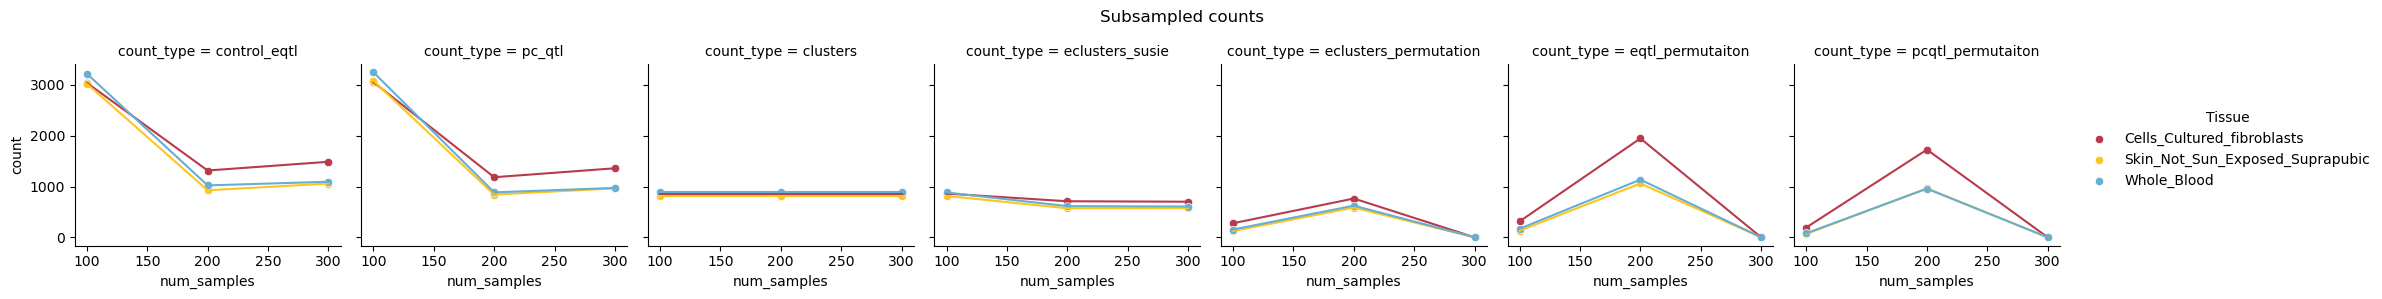

In [84]:
g = sns.FacetGrid(joined_counts, col="count_type", hue='Tissue', palette = tissue_pal)
g.map(sns.lineplot, "num_samples", "count")
g.map(sns.scatterplot, "num_samples", "count")
g.add_legend()
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('Subsampled counts')

look at p values for each snp

In [59]:
sub_overlaps = {}
pc_nominals = {}
e_nominals = {}
for num_samples in subsample_nums:
    sub_overlaps[num_samples] = load_overlap(sub_config[num_samples], tissue_id)
    sub_overlaps[num_samples]['cs_size']=sub_overlaps[num_samples]['variant_list'].str.split(',').apply(len) 
    pc_nominals[num_samples] = load_pc_nominal(sub_config[num_samples], tissue_id, get_var_position=True)
    e_nominals[num_samples] = load_e_nominal(sub_config[num_samples], tissue_id, get_var_position=True)

In [10]:
e_nominals[100]['is_lead'] = e_nominals[100]['variant_id'].isin(sub_overlaps[100]['lead_variant_id'])
e_nominals[200]['is_lead'] = e_nominals[200]['variant_id'].isin(sub_overlaps[200]['lead_variant_id'])
e_nominal_merged = pd.merge(left=e_nominals[100], right=e_nominals[200],left_on=['phenotype_id', 'variant_id'], right_on=['phenotype_id', 'variant_id'], suffixes=['_100', '_200'])

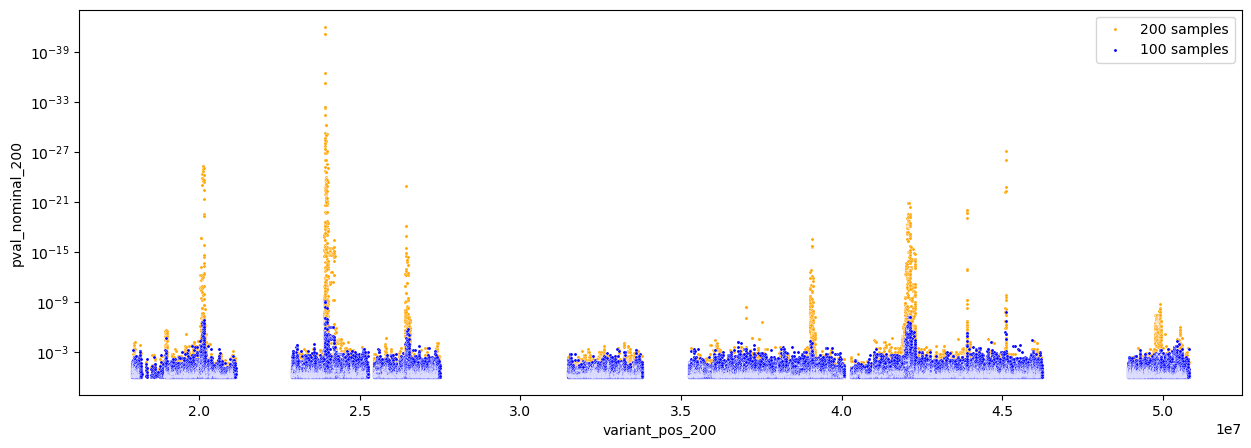

In [11]:
fig, ax = plt.subplots(figsize=(15,5))
sns.scatterplot(e_nominal_merged, y='pval_nominal_200', x='variant_pos_200', ax=ax, color='orange', s=5, label='200 samples')
sns.scatterplot(e_nominal_merged, y='pval_nominal_100', x='variant_pos_100', ax=ax, color='blue', s=5, label='100 samples')

ax.set_yscale('log')
ax.invert_yaxis()


In [41]:
cs_sizes={}
for num_samples in sub_overlaps.keys():
    cs_sizes[num_samples] = pd.Series(sub_overlaps[num_samples][(sub_overlaps[num_samples]['lead_variant_id'].str.contains('chr22'))&(sub_overlaps[num_samples]['orig_cs_dataset']=='control_eqtl')]['variant_list'].str.split(',').apply(len).values)

cs_sizes = pd.DataFrame(pd.concat(cs_sizes, names=['num_samples', 'idx']), columns=['cs_size'])

Text(0.5, 24.140625, 'credible set size')

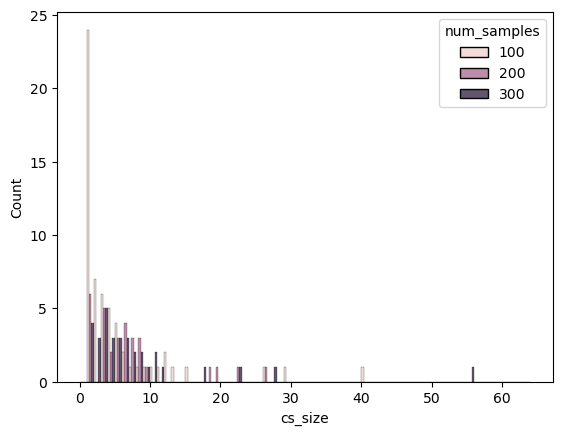

In [43]:
sns.histplot(x='cs_size', data=cs_sizes, hue='num_samples', multiple='dodge', bins=range(0, cs_sizes['cs_size'].max()))

ax.set_ylabel('Count')
ax.set_xlabel('credible set size')

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
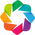

In [48]:
import holoviews as hv
hv.extension('bokeh')

In [49]:
# get the counts for unique lead vars 
subset_counts = up.query(up.from_contents({'100':sub_overlaps[100]['lead_variant_id'].unique(),
 '200':sub_overlaps[200]['lead_variant_id'].unique()})).subset_sizes

subset_counts = pd.DataFrame(subset_counts)

subset_counts['source'] = [('' if value else 'Not ') + 'QTL w/ 100' for value in subset_counts.index.get_level_values('100')]
subset_counts['target'] = [('' if value else 'Not ') + 'QTL w/ 200' for value in subset_counts.index.get_level_values('200')]

# sort the target and source to be QTLs on the bottom, not QTLs on the top 
subset_counts['source'] = pd.Categorical(subset_counts['source'], ["QTL w/ 100", "Not QTL w/ 100"])
subset_counts['target'] = pd.Categorical(subset_counts['target'], ["QTL w/ 200", "Not QTL w/ 200"])

subset_counts.sort_values(['source', 'target'], inplace=True)

sankey = hv.Sankey(subset_counts, label='Shared lead vars 100 vs 200 subsamples', vdims='size')
sankey.opts(label_position='left', edge_color='target', cmap='tab20')

:Sankey   [source,target]   (size)

In [ ]:
def get_cs_overlap(row, var_list):
    return sum(var_list.isin(row['variant_list_2'])) > 0

sub_overlaps[100]['variant_list_2'] = sub_overlaps[100]['variant_list'].apply(ast.literal_eval)
vars_100 = sub_overlaps[100]['variant_list_2'].explode()

sub_overlaps[200]['variant_list_2'] = sub_overlaps[200]['variant_list'].apply(ast.literal_eval)
vars_200 = sub_overlaps[200]['variant_list_2'].explode()

sub_overlaps[100]['200_overlap'] = sub_overlaps[100].progress_apply(get_cs_overlap, axis=1, args=(vars_200,))
sub_overlaps[200]['100_overlap'] = sub_overlaps[200].progress_apply(get_cs_overlap, axis=1, args=(vars_100,))

In [50]:
subset_counts.loc[(True,True), 'size'] = sum(sub_overlaps[100]['200_overlap'])
subset_counts.loc[(False,True), 'size'] = len(sub_overlaps[100]) - sum(sub_overlaps[100]['200_overlap'])
subset_counts.loc[(True,False), 'size'] = len(sub_overlaps[200]) - sum(sub_overlaps[200]['100_overlap'])

In [73]:
subset_counts = pd.DataFrame(subset_counts)

subset_counts['source'] = [('' if value else 'Not ') + 'part of cs w/ 100' for value in subset_counts.index.get_level_values('100')]
subset_counts['target'] = [('' if value else 'Not ') + 'part of cs w/ 200' for value in subset_counts.index.get_level_values('200')]

# sort the target and source to be QTLs on the bottom, not QTLs on the top 
subset_counts['source'] = pd.Categorical(subset_counts['source'], ["part of cs w/ 100", "Not part of cs w/ 100"])
subset_counts['target'] = pd.Categorical(subset_counts['target'], ["part of cs w/ 200", "Not part of cs w/ 200"])

subset_counts.sort_values(['source', 'target'], inplace=True)

sankey = hv.Sankey(subset_counts, label='Credible set overlap 100 vs 200 subsample', vdims='size')
sankey.opts(label_position='left', node_color='index', cmap='tab20')

:Sankey   [source,target]   (size)

<AxesSubplot: xlabel='cs_size', ylabel='Count'>

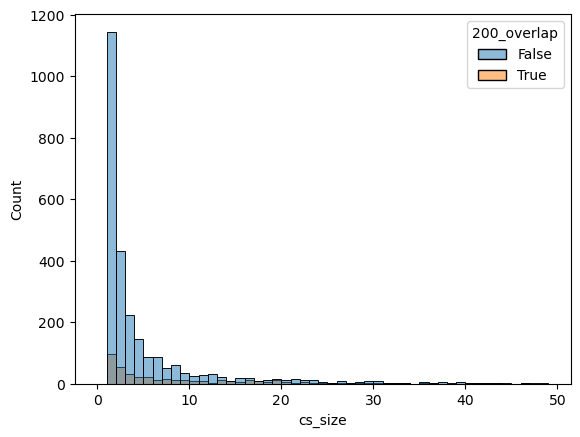

In [72]:
# color 100 vs 200 histogram by the above categories


sns.histplot(x='cs_size', data=sub_overlaps[100][(sub_overlaps[100]['orig_cs_dataset']=='control_eqtl')], hue='200_overlap', bins=range(0,50))